In [1]:
import matplotlib.pyplot as plt
import cv2
from skimage import color
from skimage import io
from skimage.viewer import ImageViewer
from skimage.exposure import match_histograms
import numpy as np
import dlib
import math

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Viewer requires Qt
  """


Text(0.5, 1.0, 'source image')

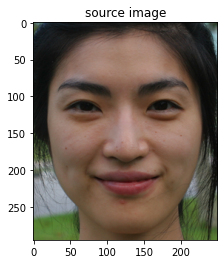

In [2]:
#subject image
subject = cv2.imread('drive/MyDrive/COL783/subject1.png')
example = cv2.imread('drive/MyDrive/COL783/example1.png')

subject = cv2.cvtColor(subject, cv2.COLOR_BGR2RGB)
example = cv2.cvtColor(example, cv2.COLOR_BGR2RGB)
plt.imshow(subject)
plt.title('source image')

Text(0.5, 1.0, 'example image')

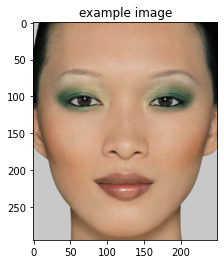

In [3]:
plt.imshow(example)
plt.title('example image')

In [4]:
def boundary_points(points, width_percent=0.1, height_percent=0.1):
  """ Produce additional boundary points
  :param points: *m* x 2 array of x,y points
  :param width_percent: [-1, 1] percentage of width to taper inwards. Negative for opposite direction
  :param height_percent: [-1, 1] percentage of height to taper downwards. Negative for opposite direction
  :returns: 2 additional points at the top corners
  """
  x, y, w, h = cv2.boundingRect(np.array([points], np.int32))
  spacerw = int(w * width_percent)
  spacerh = int(h * height_percent)
  return [[x+spacerw, y+spacerh],
          [x+w-spacerw, y+spacerh]]


def get_points_and_bounding_rectangle(image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("drive/MyDrive/COL783/shape_predictor_68_face_landmarks.dat")
    rectangles = detector(s1, 1)
    shape = None
    rectangle = None
    for k, rect in enumerate(rectangles):
        # Get the landmarks/parts for the face in box d.
        shape = predictor(image, rect)
        rectangle = rect
    print("No of Points: ",shape.num_parts);
    
    
    #plot bounding rectangle
    
    image2 = np.copy(image)
    print(rectangle)
    print("Left: ",rectangle.left(),"right: ",rectangle.right(),"bottom: ",rectangle.bottom(),"top: ",rectangle.top())
    cv2.rectangle(image2, (rectangle.left(), rectangle.top()), (rectangle.right(), rectangle.bottom()), (0, 255, 0), 2)
   
    
    #get points
    
    points_and_indices = []
    '''
    for i in range(shape.num_parts):
        x = shape.part(i).x
        y = shape.part(i).y
        point = np.array([x, y])
        index = i
        point_and_index = (point, index)
        points_and_indices.append(point_and_index)
    '''    
    points_and_indices = np.array([(shape.part(i).x, shape.part(i).y) for i in range(68)], np.int32)
    add_boundary_points = True; #True;
    if add_boundary_points:
        # Add more points inwards and upwards as dlib only detects up to eyebrows
        points_and_indices = np.vstack([
          points_and_indices,
          boundary_points(points_and_indices, 0.1, -0.03),
          boundary_points(points_and_indices, 0.14, -0.06),
          boundary_points(points_and_indices, 0.17, -0.12),
          boundary_points(points_and_indices, 0.35, -0.25),
          boundary_points(points_and_indices, 0.40, -0.25)])
       
    #plot points
    image3 = np.copy(image);
    for i,point_and_index in enumerate(points_and_indices):
        pt1 = (point_and_index[0], point_and_index[1])
        font = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(image3, str(i), pt1, font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    

    f, axArr = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
    plt.sca(axArr[0]); 
    plt.imshow(image2); 
    plt.title('Rectangular Image')
    plt.sca(axArr[1]); 
    plt.imshow(image3); 
    plt.title('Points  Image')  
    
    return shape,rectangle,points_and_indices

In [5]:
def dimension_check(d,point):
    if (point[0] < d[0] or point[0] > d[1]):
        return False
    elif (point[1] < d[0] or point[1] > d[2]):
        return False
    return True

def traingualize(image,index_points,shape):
    

    rectangle = (0, 0, image.shape[1], image.shape[0])
    delaunay  = cv2.Subdiv2D(rectangle)
    #for k in range(shape.num_parts):
    for point in index_points:
        delaunay.insert((point[0], point[1]))
    triangleList = delaunay.getTriangleList() 
    print("No. of Traingles: ",len(triangleList))
    
    #Draw Traingles
    image1 = np.copy(image);
    dimension = [0, image1.shape[1], image1.shape[0]]
    color = (0,255,0)
    for t in triangleList:
        pt1 = (int(t[0]), int(t[1]))
        pt2 = (int(t[2]), int(t[3]))
        pt3 = (int(t[4]), int(t[5]))

        if dimension_check(dimension, pt1) and dimension_check(dimension, pt2) and dimension_check(dimension, pt3) :
                cv2.line(image1, pt1, pt2, color, 1)
                cv2.line(image1, pt2, pt3, color, 1)
                cv2.line(image1, pt3, pt1, color, 1)
    plt.imshow(image1);    
    return triangleList 

In [6]:
def warp1(image1,image2):
    shape1,rectangle1,points1 = get_points_and_bounding_rectangle(image1)
    shape2,rectangle2,points2 = get_points_and_bounding_rectangle(image2)
    triangleList1 = traingualize(image1,points1,shape1)
    triangleList2 = traingualize(image2,points2,shape2)
    output = np.ones(image1.shape, dtype='float32')
    plt.imshow(output)
    invalid = 0
    for i in range(len(triangleList1)):
            # Affine Transformation
            triangle = np.reshape(triangleList1[i, :], newshape=(3, 2))
            triangle2 = triangle.astype('float32')
            pt_num=[]
            # triangle inside points list
            for pt in triangle2:
                for iter,k in enumerate(points1):
                    if(pt[0] == k[0] and pt[1] == k[1]):
                        pt_num.append(iter)
            #break
            src = np.ndarray(shape=(3, 2))
            if(len(pt_num)!=3):
                invalid = invalid+1
                continue
            for i, num in enumerate(pt_num):
                src[i, :] = points2[num]
            triangle1 = src.astype(dtype='float32')

            r1 = cv2.boundingRect(triangle1) 
            r2 = cv2.boundingRect(triangle2)
            tri1Cropped = []
            tri2Cropped = []
            for i in range(3):
                tri1Cropped.append(((triangle1[i][0] - r1[0]),(triangle1[i][1] - r1[1])))
                tri2Cropped.append(((triangle2[i][0] - r2[0]),(triangle2[i][1] - r2[1])))
            img1Cropped = image1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
            warpMat = cv2.getAffineTransform(np.float32(tri1Cropped), np.float32(tri2Cropped))
            img2Cropped = cv2.warpAffine( img1Cropped, warpMat, (r2[2], r2[3]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

            # Get mask by filling triangle
            mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)

            cv2.fillConvexPoly(mask, np.int32(tri2Cropped), (1.0, 1.0, 1.0), 16, 0);
            # Apply mask to cropped region
            img2Cropped = img2Cropped * mask

            # Copy triangular region of the rectangular patch to the output image
            output[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = output[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
            output[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = output[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Cropped
    return output.astype('uint8')            

In [7]:
def warp2(src, dst):
    shape1,rectangle1,points1 = get_points_and_bounding_rectangle(src)
    shape2,rectangle2,points2 = get_points_and_bounding_rectangle(dst)
    triangleList1 = traingualize(src,points1,shape1)
    triangleList2 = traingualize(dst,points2,shape2)
    src_points = points1
    dst_points = points2
    src_triangles = triangleList1
    dst_triangles = triangleList2
    
    #src_points, src_triangles = facial_landmark.triangulate(src)
    #dst_points, dst_triangles = facial_landmark.triangulate(dst)
    warped_image = np.zeros(src.shape, dtype=np.uint8)

    for i,t in enumerate(dst_triangles):
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        first, second, third = -1,-1,-1
        for i2, (x,y) in enumerate(dst_points):
            if(x==t[0] and y==t[1]):
                #print('triangle '+(i)+' has first point at '+str(i2))
                #print(x,y)
                #cv2.circle(src,(x,y), 1, (i*2,0,i*3), -1)
                first = i2
            if(x==t[2] and y==t[3]):
                #print('triangle '+str(i)+' has second point at '+str(i2))
                #print(x,y)
                #cv2.circle(src,(x,y), 1, (i*2,0,i*3), -1)
                second = i2
            if(x==t[4] and y==t[5]):
                #print('triangle '+str(i)+' has third point at '+str(i2))
                #print(x,y)
                #cv2.circle(src,(x,y), 1, (i*2,0,i*3), -1)
                third = i2
        if(first>=0 and second>=0 and third>=0):
            x1,y1 = src_points[first]
            x2,y2 = src_points[second]
            x3,y3 = src_points[third]
            dx1,dy1 = dst_points[first]
            dx2,dy2 = dst_points[second]
            dx3,dy3 = dst_points[third]

            #creating mask in destination image
            mask = np.zeros(src.shape, dtype=np.uint8)
            roi_corners = np.array([[dx1,dy1],[dx2,dy2],[dx3,dy3]], dtype=np.int32)
            cv2.fillPoly(mask, [roi_corners], (255,255,255))

            #warping src image to destination image
            pts1 = np.float32([[x1,y1],[x2,y2],[x3,y3]])
            pts2 = np.float32([[dx1,dy1],[dx2,dy2],[dx3,dy3]])
            M = cv2.getAffineTransform(pts1,pts2)
            rows,cols,ch = src.shape
            res = cv2.warpAffine(src,M,(cols,rows))

            warped_image = cv2.bitwise_or(warped_image,cv2.bitwise_and(mask,res))
            #cv2.imshow('masked_image', warped_image)
            #cv2.waitKey(0)
            '''
            cv2.line(src, pt1, pt2, (255, 255, 255), 1, cv2.LINE_AA, 0)
            cv2.line(src, pt2, pt3, (255, 255, 255), 1, cv2.LINE_AA, 0)
            cv2.line(src, pt3, pt1, (255, 255, 255), 1, cv2.LINE_AA, 0)
            '''
    #cv2.imshow('res',warped_image)
    #cv2.waitKey(0)
    return warped_image

In [8]:
def warp_example_to_subject(example, subject):
    s =  np.copy(subject)
    x =  np.copy(example)
    subject_face = warp_face_image_1_to_2(s, s)
    output = s - subject_face
    warped_example = warp_face_image_1_to_2(s, x)
    output = output + warped_example
    return output

In [9]:
def all_regions(image):
    #36 to 41  is left eye
    #42 to 47 is right eye
    #60 to 67 is mouth cavity
    #48 to 59 is lips c2
    #rest is considered skin area c1
    #27-35: nose

    shape,rectangle,points = get_points_and_bounding_rectangle(image)   
    left_eye=[]
    right_eye=[]
    cavity = []
    lips = []
    skin = []
    left_brow=[]
    right_brow=[]

    for i,point in enumerate(points):
        if(17<=i<=21):
            left_brow.append(point)
        if(22<=i<=26):
            right_brow.append(point)
        if(48<=i<=59):
            lips.append(point)
        if(36<=i<=41):
            left_eye.append(point)
        if(42<=i<=47):
            right_eye.append(point)
        if(60<=i<=67):
            cavity.append(point)

        else:
            skin.append(point)

    return [left_eye, right_eye, cavity, lips, skin, left_brow, right_brow]

def createMask(image):

    regions = all_regions(image)
    rows = image.shape[0]
    cols = image.shape[1]
    masks = []

    for i, region in enumerate(regions):
        hull_contours = cv2.convexHull(np.vstack(np.array(region)))
        hull = np.vstack(hull_contours)
        # black image
        mask = np.zeros((rows, cols), dtype=np.uint8)
        # blit our contours onto it in white color
        cv2.drawContours(mask, [hull], 0, 1, -1)
        masks.append(mask)
    
    masks.append(np.copy((masks[4] - (masks[3]-masks[2])) - (masks[0]+masks[1]+masks[2])))
    masks.append(np.copy(masks[3]-masks[2]))
    masks.append(np.copy(masks[0]+masks[1]+masks[2]))
    #masks[4] = masks[4] - masks[0] - masks[1] - masks[2] - masks[3] - masks[5] - masks[6]
    return masks

In [10]:
#calculate Area by  co-ordinates
def calculate_area(pts):
    x1 = pts[0][1]
    x2 = pts[1][1]
    x3 = pts[2][1]
    y1 = pts[0][0]
    y2 = pts[1][0]
    y3 = pts[2][0]
    return math.fabs((x1*(y2-y3)+x2*(y3-y1)+x3*(y1-y2))/2.0)


def warp3(src,dst):
    
     #src -> makeup -> example
    
    #dst -> without makeup -> subject 
    global mask
    global mask2
    global croped
    global area_triangle_2
    global roi_corners
    global ignoredPoints
    global totalPoints
    global approximatedPoints
    ignoredPoints = 0
    totalPoints = 0
    approximatedPoints = 0
    
    shape1,rectangle1,points1 = get_points_and_bounding_rectangle(src)
    shape2,rectangle2,points2 = get_points_and_bounding_rectangle(dst)
    triangleList1 = traingualize(src,points1,shape1)
    triangleList2 = traingualize(dst,points2,shape2)
    src_points = points1
    dst_points = points2
    src_triangles = triangleList1
    dst_triangles = triangleList2
    
    #src_points, src_triangles = facial_landmark.triangulate(src)
    #dst_points, dst_triangles = facial_landmark.triangulate(dst)
    warped_image = np.zeros(dst.shape, dtype=np.uint8)
    #warped_image = np.copy(dst)
    for i,t in enumerate(dst_triangles):
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        first, second, third = -1,-1,-1
        for i2, (x,y) in enumerate(dst_points):
            if(x==t[0] and y==t[1]):
                #print('triangle '+(i)+' has first point at '+str(i2))
                #print(x,y)
                #cv2.circle(src,(x,y), 1, (i*2,0,i*3), -1)
                first = i2
            if(x==t[2] and y==t[3]):
                #print('triangle '+str(i)+' has second point at '+str(i2))
                #print(x,y)
                #cv2.circle(src,(x,y), 1, (i*2,0,i*3), -1)
                second = i2
            if(x==t[4] and y==t[5]):
                #print('triangle '+str(i)+' has third point at '+str(i2))
                #print(x,y)
                #cv2.circle(src,(x,y), 1, (i*2,0,i*3), -1)
                third = i2
        if(first>=0 and second>=0 and third>=0):
            x1,y1 = src_points[first]
            x2,y2 = src_points[second]
            x3,y3 = src_points[third]
            dx1,dy1 = dst_points[first]
            dx2,dy2 = dst_points[second]
            dx3,dy3 = dst_points[third]
            
           
            
            
            
            #creating mask in destination image
            mask = np.zeros(dst.shape, dtype=np.uint8)
            roi_corners = np.array([[dx1,dy1],[dx2,dy2],[dx3,dy3]], dtype=np.int32)
            cv2.fillPoly(mask, [roi_corners], (255,255,255))
            #rect = cv2.boundingRect(roi_corners)
            #x,y,w,h = rect
            #print(y,h,x,w)
            #croped = dst[y:y+h, x:x+w].copy()
            
            #plt.show(mask)

            #warping src image to destination image
            pts1 = np.array([[x1,y1],[x2,y2],[x3,y3]])
            pts2 = np.array([[dx1,dy1],[dx2,dy2],[dx3,dy3]])
            
            #print("pts1: = ", pts1)
            #print("pts2: =  ", pts2)
            
            #area of traingle
            area_triangle_2 = calculate_area(np.float32(pts2))
            
            #interpolating the endpoints of triangle
            # src -> toBeMorped -> pts1->vertex1Im1
            #dst -> FeaturesTakenFrom-> pts2->vertex1Im2
            
            
            
            warped_image[pts2[0][1],pts2[0][0]] = src[pts1[0][1],pts1[0][0]]
            warped_image[pts2[1][1],pts2[0][0]] = src[pts1[1][1],pts1[1][0]]
            warped_image[pts2[2][1],pts2[0][0]] = src[pts1[2][1],pts1[2][0]]
            
            
            
             # For Triangle in second image
            minX = min(pts2[0][1],pts2[1][1],pts2[2][1])
            maxX = max(pts2[0][1],pts2[1][1],pts2[2][1])
            minY = min(pts2[0][0],pts2[1][0],pts2[2][0])
            maxY = max(pts2[0][0],pts2[1][0],pts2[2][0])
            
            for xpos in range(minX,maxX+1,1):
                for ypos in range(minY,maxY+1,1):
                   
                    '''
                            #change to grayscale
                    mask2 = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
                    #get non-zero co-ordinates in triangle
                    X_array,Y_array = np.nonzero(mask2)

                    for xpos,ypos in zip(X_array,Y_array):
                    '''            
                    #dst vertex
                    vertex = np.array([ypos,xpos])
                    #if vertex in pts2:
                       # continue
                    area1 = calculate_area(np.float32([vertex,pts2[0],pts2[1]]))
                    area2 = calculate_area(np.float32([vertex,pts2[1],pts2[2]]))
                    area3 = calculate_area(np.float32([vertex,pts2[0],pts2[2]]))
                    
                    
                    
                    totalPoints = totalPoints + 1;
                    avalue = 0.1
                    if(area1+area2+area3 != area_triangle_2):
                        continue
                    '''
                    if(area1+area2+area3 > area_triangle_2):
                        area_array = [area1,area2,area3]
                        maxarg = np.argmax(area_array)
                        if(maxarg==0):
                            if(area2+area3 > area_triangle_2):
                                ignoredPoints = ignoredPoints+1
                                continue
                            else:    
                                
                                oldarea = area1
                                area1 = area_triangle_2 - (area2+area3) 
                                if(math.fabs((oldarea-area1)/oldarea)>avalue):
                                    ignoredPoints = ignoredPoints+1
                                    continue
                                approximatedPoints = approximatedPoints + 1    
                        elif(maxarg==1):
                            if(area1+area3 > area_triangle_2):
                                ignoredPoints = ignoredPoints+1
                                continue
                            else:    
                                
                                oldarea = area2
                                area2 = area_triangle_2 - (area1+area3)
                                if(math.fabs((oldarea-area2)/oldarea)>avalue):
                                    ignoredPoints = ignoredPoints+1
                                    continue
                                approximatedPoints = approximatedPoints + 1    
                        else:
                            if(area2+area1 > area_triangle_2):
                                ignoredPoints = ignoredPoints+1
                                continue
                            else:    
                                oldarea = area3
                                
                                area3 = area_triangle_2 - (area2+area1)      
                                if(math.fabs((oldarea-area3)/oldarea)>avalue):
                                    ignoredPoints = ignoredPoints+1
                                    continue
                                approximatedPoints = approximatedPoints + 1
                            
                    '''   
                    bc1 =  area1/area_triangle_2
                    bc2 =  area2/area_triangle_2
                    bc3 =  area3/area_triangle_2  
                    vertex_in_im2 = pts1[2]*bc1 + pts1[0]*bc2 + pts1[1]*bc3
                    vertex_in_im2 = vertex_in_im2.astype(np.int)
                    #if(src[vertex_in_im2[1],vertex_in_im2[0]]==np.array([0,0,0])).all():
                        
                    #print("src Vertex: ",vertex_in_im2,"value :",src[vertex_in_im2[1],vertex_in_im2[0]])
                    
                    warped_image[vertex[1],vertex[0]] = src[vertex_in_im2[1],vertex_in_im2[0]]
                    #print("out3 Vertex: ",vertex,"value :",warped_image[vertex[1],vertex[0]])
            
            '''       
            M = cv2.getAffineTransform(pts1,pts2)
            rows,cols,ch = src.shape
            res = cv2.warpAffine(src,M,(cols,rows))

            warped_image = cv2.bitwise_or(warped_image,cv2.bitwise_and(mask,res))
            '''
            
            #break
            #cv2.imshow('masked_image', warped_image)
            #cv2.waitKey(0)
            '''
            cv2.line(src, pt1, pt2, (255, 255, 255), 1, cv2.LINE_AA, 0)
            cv2.line(src, pt2, pt3, (255, 255, 255), 1, cv2.LINE_AA, 0)
            cv2.line(src, pt3, pt1, (255, 255, 255), 1, cv2.LINE_AA, 0)
            '''
            #print(i)
            #if(i==0):
             #   break;
    #cv2.imshow('res',warped_image)
    #cv2.waitKey(0)
    print("total POints : ",totalPoints)
    print("Ignored Points : ",ignoredPoints)
    print("Approximated Points : ",approximatedPoints)
    return warped_image

In [11]:
def gaussian_function(x,sigma):
  result = (1/np.sqrt(2*np.pi*sigma**2))*np.exp((-x**2)/(2*sigma**2))
  return result

In [12]:
def bilateral_filter(img, sigma_s=16, sigma_r=0.8,ksize=20):
  padding = (ksize - 1)/2
  temp = np.copy(img)
  temp = np.pad(temp,np.int(padding))

  result = np.zeros(img.shape)

  for i in range(temp.shape[0]):
    for j in range(temp.shape[1]):
      if (i + ksize < temp.shape[0] and j + ksize < temp.shape[1]):
        qx = i + np.int((ksize-1)/2)
        qy = j + np.int((ksize-1)/2)
        Wp = 0
        sum = 0
        for i1 in range(ksize):
          for j1 in range(ksize):
            x = i + i1
            y = j + j1
            dist = np.sqrt((qx-x)**2 + (qy-y)**2)
            l = abs(temp[x,y] - temp[qx,qy])
            gauss1 = gaussian_function(dist,sigma_s)
            gauss2 = gaussian_function(l,sigma_r)
            Wp = Wp + gauss1*gauss2
            sum = sum + gauss1*gauss2*temp[x,y]
        if (qx < img.shape[0] and qy < img.shape[1]):
          result[qx,qy] = sum/Wp

  return result

In [13]:
def layer_decomposition(img):
  LABimg = color.rgb2lab(img)
  L = np.float32(LABimg[:,:,0]) # lightness layer
  l1 = np.copy(L)
  face_str = cv2.bilateralFilter(l1,10,70,70) #face structure layer
  #face_str = bilateral_filter(l1)
  face_str 
  mask = createMask(img)
  #skin_detail = (L - face_str)*(mask_subject[4] - mask_subject[3] - mask_subject[0] - mask_subject[1])  #skin detail layer
  skin_detail = (L - face_str)
  color_layer = LABimg[:,:,1:] #color layer
  '''
  #plotting the layers
  f, axArr = plt.subplots(nrows=1,ncols=3,figsize=(10,10))
  
  plt.sca(axArr[0])
  plt.imshow(face_str,cmap='gray')
  plt.title('Face structure')

  plt.sca(axArr[1])
  plt.imshow(skin_detail, cmap='gray')
  plt.title('Skin detail')

  colorimage = color_layer[:,:,0]
  #left half of image is alpha channel
  x = int(colorimage.shape[0]/2)
  y = colorimage.shape[1]
  #right half of image is beta channel
  #-20 to align the vertical line on nose
  colorimage[:,x-20:] = color_layer[:,x-20:,1]
  plt.sca(axArr[2])
  plt.imshow(colorimage,cmap='gray')
  plt.title('Color (a*,b*)')
  '''
  return [face_str, skin_detail,color_layer]



In [14]:
#skin detail transfer
def skin_detail_transfer(subject_skin_layer, example_skin_layer,mask, ws=0.2):
  #weight corresponding to subject
  we = 1 - ws #weight corresponding to example
  result = (ws*subject_skin_layer + we*example_skin_layer)
  return result

In [15]:
def color_transfer(masks, subject_color_layer, example_color_layer, r = 0.5):

    #result_color = subject_color_layer
    result_color = np.zeros(subject_color_layer.shape)
    mask = masks[9]
    for i in range(result_color.shape[0]):
        for j in range(result_color.shape[1]):
            if (mask[i, j] == 0):
                result_color[i, j] = (1-r)*subject_color_layer[i, j] + r*example_color_layer[i, j]
            else:
                result_color[i, j] = subject_color_layer[i, j]
            
            if (masks[4][i,j] == 0):
              result_color[i,j] = subject_color_layer[i,j]
    return result_color

In [16]:
e1 = np.copy(example)
s1 = np.copy(subject)

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


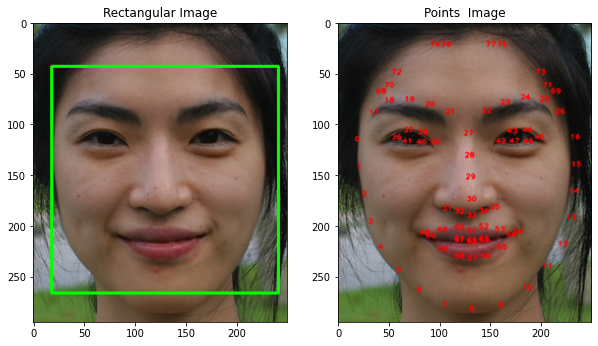

In [17]:
sh1, re1, po1 = get_points_and_bounding_rectangle(s1)

No. of Traingles:  129


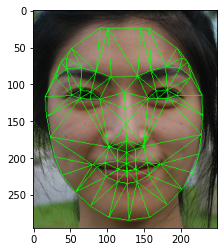

In [18]:
tl1=traingualize(s1,po1,sh1)

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


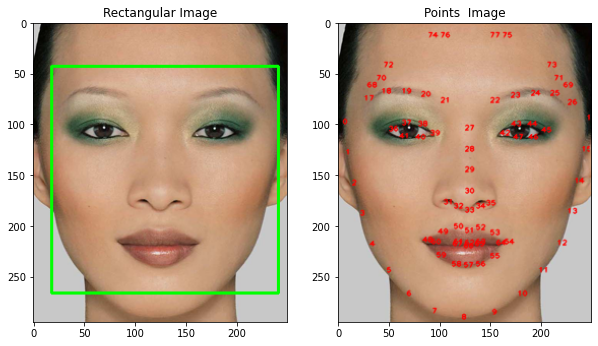

In [19]:
sh2,re2,po2 = get_points_and_bounding_rectangle(e1)

No. of Traingles:  129


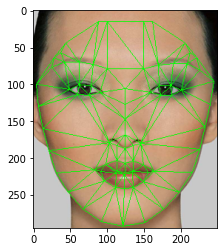

In [20]:
tl2=traingualize(e1,po2,sh2)

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No. of Traingles:  129
No. of Traingles:  129
total POints :  123753
Ignored Points :  0
Approximated Points :  0


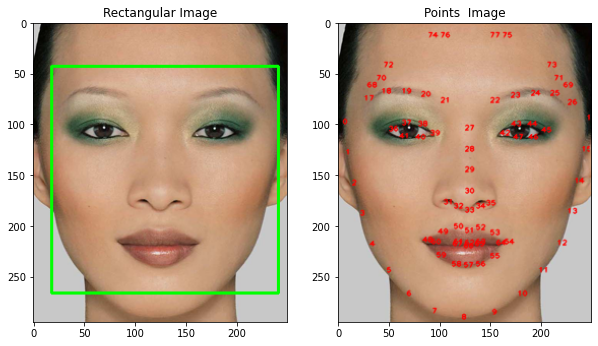

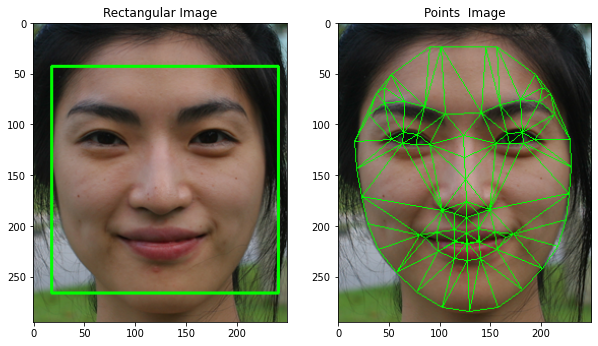

In [21]:
out2= warp3(e1,s1)

Text(0.5, 1.0, 'result of face alignment')

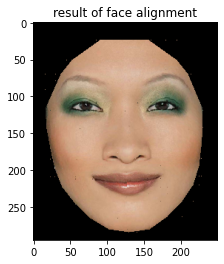

In [22]:
plt.imshow(out2)
plt.title('result of face alignment')

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


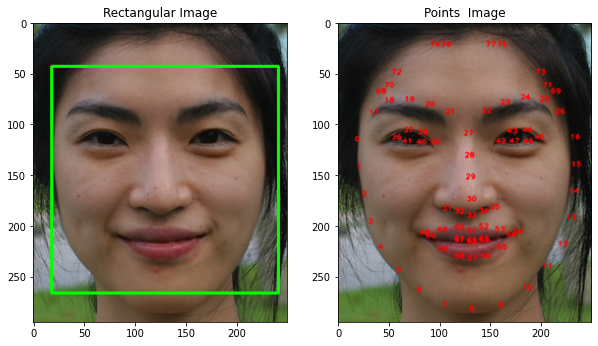

In [23]:
#mask
#0,1: eye cavity
#2: mouth_cavity
#3: lips
#4: face
#5,6 : eyebrows
#7: C1
#8: C2
#9: C3
mask_subject = createMask(s1)

Text(0.5, 1.0, 'C3: eyes and mouth cavity')

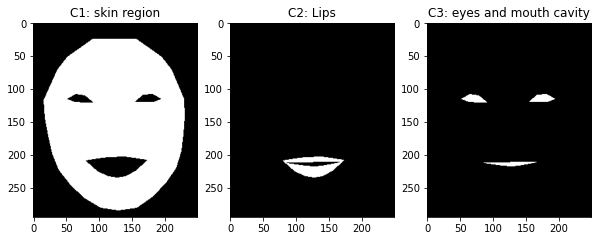

In [24]:
f, axArr = plt.subplots(nrows=1,ncols=3,figsize=(10,10))

plt.sca(axArr[0])
plt.imshow(mask_subject[7],cmap='gray')
plt.title('C1: skin region')

plt.sca(axArr[1])
plt.imshow(mask_subject[8],cmap='gray')
plt.title('C2: Lips')

plt.sca(axArr[2])
plt.imshow(mask_subject[9],cmap='gray')
plt.title('C3: eyes and mouth cavity')

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


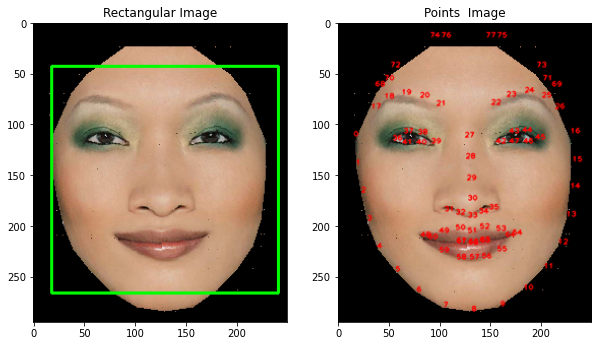

In [25]:
mask_example = createMask(out2)

Text(0.5, 1.0, 'C3: eyes and mouth cavity')

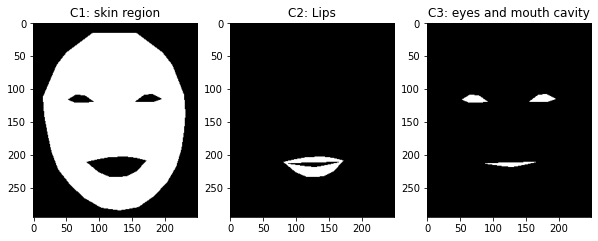

In [26]:
f, axArr = plt.subplots(nrows=1,ncols=3,figsize=(10,10))

plt.sca(axArr[0])
plt.imshow(mask_example[7],cmap='gray')
plt.title('C1: skin region')

plt.sca(axArr[1])
plt.imshow(mask_example[8],cmap='gray')
plt.title('C2: Lips')

plt.sca(axArr[2])
plt.imshow(mask_example[9],cmap='gray')
plt.title('C3: eyes and mouth cavity')

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


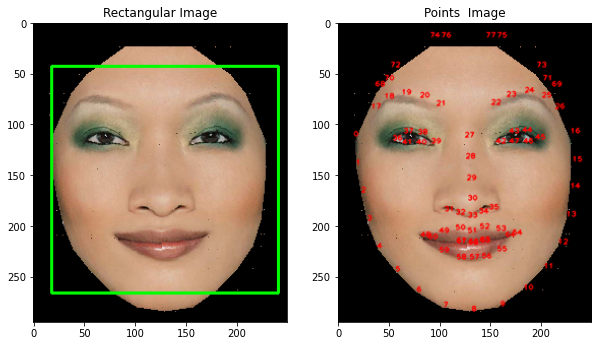

In [27]:
#face_structure, skin detail and color 
example_layers = layer_decomposition(out2)

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
(295, 250)


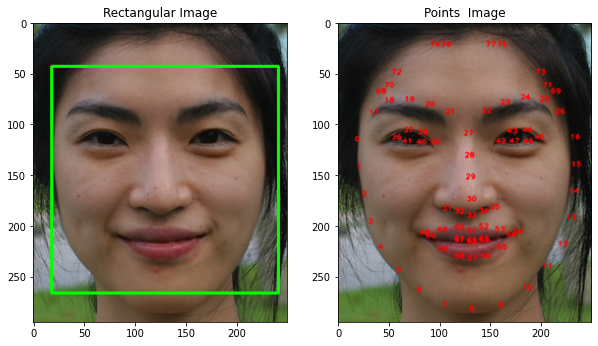

In [28]:
#face_structure, skin detail and color 
subject_layers = layer_decomposition(s1)
print(subject_layers[0].shape)

Text(0.5, 1.0, 'Skin Detail Layer (example)')

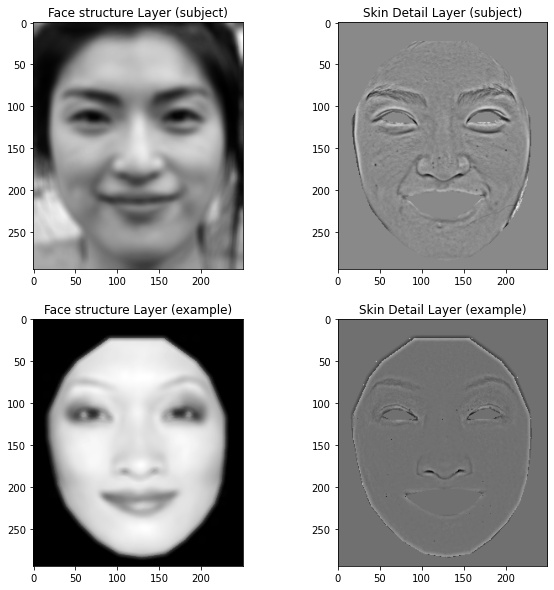

In [29]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(subject_layers[0],cmap='gray')
plt.title('Face structure Layer (subject)')
plt.subplot(2,2,2)
plt.imshow(subject_layers[1]*(mask_subject[4]-mask_subject[1]-mask_subject[0]-mask_subject[3]),cmap='gray')
plt.title('Skin Detail Layer (subject)')
plt.subplot(2,2,3)
plt.imshow(example_layers[0],cmap='gray')
plt.title('Face structure Layer (example)')
plt.subplot(2,2,4)
plt.imshow(example_layers[1]*(mask_example[4]-mask_example[1]-mask_example[0]-mask_example[3]),cmap='gray')
plt.title('Skin Detail Layer (example)')

Text(0.5, 1.0, 'Beta')

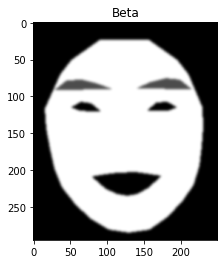

In [30]:
#obtaining beta
beta = mask_subject[7] - 0.7*(mask_subject[5]+mask_subject[6])
plt.imshow(beta,cmap='gray')
plt.title('Unsmoothed version of beta values')

#beta should change smoothly across image
smooth_beta = cv2.GaussianBlur(beta,(9,9),0)
plt.imshow(smooth_beta,cmap='gray')
plt.title('Beta')

In [31]:
'''
#beta formula
#beta formula
#math.exp(65)

#br = cv2.boundingRect(s1)
#grayImage = cv2.cvtColor(mask_subject[4], cv2.COLOR_RGB2GRAY)
#plt.imshow(grayImage,cmap='gray')
width = sum((mask_subject[4] > 0).any(axis=0))
height =  sum((mask_subject[4] > 0).any(axis=1))
print('width:', width)
print('height:', height)

beta_p = np.zeros((s1.shape[0],s1.shape[1]))

def getk(x,y):
  if ((mask_subject[5]+mask_subject[6])[x,y]==1):
    return 0.7
  elif ((mask_subject[7])[x,y]==1):
    return 0.0
  else:
    return 1.0
       
sigma_square = min(width,height)/25
for i in range(s1.shape[0]):
  for j in range(s1.shape[1]):
    min_x = 0
    min_y = 0
    min_value = 10000000
    k = getk(i,j)
    for x in range(s1.shape[0]):
      for y in range(s1.shape[1]):
        sqrd_dist = -np.sqrt((x-i)**2 + (y-j)**2)            
        value = (1 - k * math.exp((sqrd_dist)/(2*sigma_square)) )
        if (value < min_value) :
          min_value = value                               
    beta_p[i,j] = min_value                       
'''       


"\n#beta formula\n#beta formula\n#math.exp(65)\n\n#br = cv2.boundingRect(s1)\n#grayImage = cv2.cvtColor(mask_subject[4], cv2.COLOR_RGB2GRAY)\n#plt.imshow(grayImage,cmap='gray')\nwidth = sum((mask_subject[4] > 0).any(axis=0))\nheight =  sum((mask_subject[4] > 0).any(axis=1))\nprint('width:', width)\nprint('height:', height)\n\nbeta_p = np.zeros((s1.shape[0],s1.shape[1]))\n\ndef getk(x,y):\n  if ((mask_subject[5]+mask_subject[6])[x,y]==1):\n    return 0.7\n  elif ((mask_subject[7])[x,y]==1):\n    return 0.0\n  else:\n    return 1.0\n       \nsigma_square = min(width,height)/25\nfor i in range(s1.shape[0]):\n  for j in range(s1.shape[1]):\n    min_x = 0\n    min_y = 0\n    min_value = 10000000\n    k = getk(i,j)\n    for x in range(s1.shape[0]):\n      for y in range(s1.shape[1]):\n        sqrd_dist = -np.sqrt((x-i)**2 + (y-j)**2)            \n        value = (1 - k * math.exp((sqrd_dist)/(2*sigma_square)) )\n        if (value < min_value) :\n          min_value = value                   

In [32]:
def highlight_and_shading_transfer(subject, example,mask):
  #applying gaussian filter before applying the laplacian filter
  #blur_subject = cv2.GaussianBlur(subject,(3,3),0)
  grad_subject = cv2.Laplacian(subject,cv2.CV_32F,ksize=1)
  
  #blur_example = cv2.GaussianBlur(example,(3,3),0)
  grad_example = cv2.Laplacian(example,cv2.CV_32F,ksize=1)

  result = np.zeros(subject.shape)

  for i in range(subject.shape[0]):
    for j in range(subject.shape[1]):
      if (beta[i,j] * abs(grad_example[i,j]) > abs(grad_subject[i,j])):
        result[i,j] = grad_example[i,j]
      else:
        result[i,j] = grad_subject[i,j]
        
  return result


In [33]:
temp = np.copy(out2)
temp1 = np.copy(s1)
LAB_example = color.rgb2lab(temp)
LAB_subject = color.rgb2lab(s1)

#match the histogram of example to the histogram of the source
equal = match_histograms(LAB_example[:,:,0],LAB_subject[:,:,0])
LAB_example[:,:,0] = equal
lip_example = []

for i in range(out2.shape[0]):
  for j in range(out2.shape[1]):
    if (mask_example[3][i][j] - mask_example[2][i][j] == 1):
      lip_example.append((i,j,LAB_example[i,j,0]))

In [34]:
def lip_makeup(subject, example, mask_subject,mask_example):
  LAB_subject = color.rgb2lab(subject)
  LAB_example = color.rgb2lab(example)
  result = np.zeros(subject.shape)

  #for each p in C2 of source, find a q in C2 of example according to the forumla
  for i in range(LAB_subject[:,:,0].shape[0]):
    for j in range(LAB_subject[:,:,1].shape[1]):
      if (mask_subject[3][i][j] - mask_subject[2][i][j] == 1):
        max_val = 0
        max_arg = (0,0)
        for k in range(len(lip_example)):
          x = lip_example[k][0]
          y = lip_example[k][1]
          l = lip_example[k][2]

          dist = np.sqrt( (x-i)**2 + (y-j)**2)
          val = abs(l - LAB_subject[i,j,0])
          t = gaussian_function(dist,5)*gaussian_function(val,5)
          if (t > max_val):
            max_val = t
            max_arg = (x,y)

        max_x = max_arg[0]
        max_y = max_arg[1]
        #print(max_x,max_y)
        result[i,j,0] = LAB_example[max_x,max_y,0]
        result[i,j,1] = LAB_example[max_x,max_y,1]
        result[i,j,2] = LAB_example[max_x,max_y,2]

  return result


In [35]:
#combining the results
#layers: face structure, skin detail and color
result = np.zeros(s1.shape)
skin_detail_layer = skin_detail_transfer(subject_layers[1],example_layers[1]*mask_subject[4],mask_example,0.7)*(mask_subject[4]-mask_subject[0]-mask_subject[1]-mask_subject[3]) + (subject_layers[1])*(1-mask_subject[4]+mask_subject[0]+mask_subject[1]+mask_subject[3])
color_layers = color_transfer(mask_subject,subject_layers[2],example_layers[2],0.8)
highlight_shading = highlight_and_shading_transfer(subject_layers[0],example_layers[0],mask_subject)
lip_layer = lip_makeup(s1,out2,mask_subject,mask_example)

#face_str_layer + skin_detail_Layer = L*
#result[:,:,0] = skin_detail_layer*(1-mask_subject[0]-mask_subject[1]-mask_subject[3]) + subject_layers[0] + subject_layers[1]*(mask_subject[0]+mask_subject[1]+mask_subject[3])
result[:,:,0] = skin_detail_layer + subject_layers[0]
result[:,:,1:] = color_layers

#add higlight and skin detail layer to L channel
result[:,:,0] = result[:,:,0] + highlight_shading 


#add lip makeup
temp1 = np.copy(result)
temp2 = np.copy(lip_layer)
temp3 = np.copy(s1)

grad_lipx = cv2.Sobel(temp2[:,:,0],cv2.CV_64F,1,0,ksize=5)
grad_lipy = cv2.Sobel(temp2[:,:,0],cv2.CV_64F,0,1,ksize=5)
grad_lip = cv2.Laplacian(temp2[:,:,0],cv2.CV_64F,ksize=1)
grad_temp1 = cv2.Laplacian(temp1[:,:,0],cv2.CV_64F,ksize=1)
grad_subject = cv2.Laplacian(temp3[:,:,0],cv2.CV_64F,ksize=1)

#result[:,:,0] = result[:,:,0] + grad_lipy*(mask_example[3] - mask_example[2]) #- grad_temp1*(mask_example[3] - mask_example[2])
#result[:,:,0] = result[:,:,0] + lip_layer[:,:,0] + grad_lip
#result[:,:,0] = np.multiply(result[:,:,0],1-mask_example[3] + mask_example[2]) + np.multiply(lip_layer[:,:,0],mask_example[3]-mask_example[2])
'''
for i in range(s1.shape[0]):
  for j in range(s1.shape[1]):
    if (mask_subject[3][i][j] - mask_subject[2][i][j] == 1):
      if (abs(grad_lip[i,j]) > abs(grad_temp1[i,j])):
        result[i,j,0] = result[i,j,0] + grad_lip[i,j]
      else:
        result[i,j,0] = result[i,j,0] + grad_temp1[i,j]
'''
result[:,:,1] = np.multiply(result[:,:,1],1-mask_subject[3] + mask_subject[2]) + np.multiply(lip_layer[:,:,1],mask_subject[3]-mask_subject[2])
result[:,:,2] = np.multiply(result[:,:,2],1-mask_subject[3] + mask_subject[2]) + np.multiply(lip_layer[:,:,2],mask_subject[3]-mask_subject[2])

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


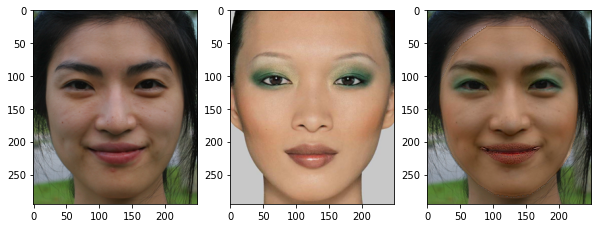

In [36]:
temp = np.copy(result)
temp[:,:,0] = temp[:,:,0] + grad_subject*(mask_subject[3]-mask_subject[2])
temp = color.lab2rgb(temp)
plt.figure(figsize=(10,10))
plt.subplot(1,3,3)
plt.imshow(temp)
plt.subplot(1,3,1)
plt.imshow(s1)
plt.subplot(1,3,2)
plt.imshow(e1)

In [37]:
#bilateral

In [38]:
def dog(img,size=(0,0),k=1.6,sigma=0.5,tuo=1):
  img1 = cv2.GaussianBlur(img,size,sigma)
  img2 = cv2.GaussianBlur(img,size,sigma*k)
  return (img1-tuo*img2)


def xdog(img,sigma=0.5,k=1.6,tuo=1,epsilon=1,phi=1):
  global xDogImg2;
  xDogImg = dog(img,sigma=sigma,k=k,tuo=tuo)/255
  xDogImg2 = np.copy(xDogImg)
  #thresholding with a continuous ramp
  for i in range(0,xDogImg.shape[0]):
    for j in range(0,xDogImg.shape[1]):
      #print(xDogImg[i,j],epsilon)
      if (xDogImg[i,j] >= epsilon):
        xDogImg[i,j] = 1*255
      else:
        xDogImg[i,j] = 255*(1 + np.tanh(phi*(xDogImg[i,j]-epsilon)))
        #print(np.tanh(phi*(xDogImg[i,j]-epsilon)))
  return xDogImg

In [39]:
def xdog_new_variant(img,sigma=0.5,k=1.6, gamma=1,epsilon=1,phi=1):
    aux = dog(img,sigma=sigma,k=k,tuo=gamma)/255
    for i in range(0,aux.shape[0]):
        for j in range(0,aux.shape[1]):
            if(aux[i,j] < epsilon):
                aux[i,j] = 255
            else:
                aux[i,j] = 255*(1 + np.tanh(phi*(aux[i,j])))
    return aux

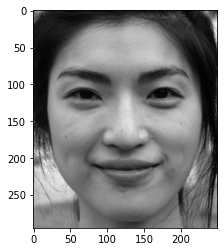

In [40]:
img = plt.imread('drive/MyDrive/COL783/subject1.png') 
img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
xdog_img = xdog_new_variant(img_cv,sigma=0.4,k=0.1,gamma=0.1,epsilon=-0.5,phi=10)
plt.imshow(xdog_img,cmap='gray')

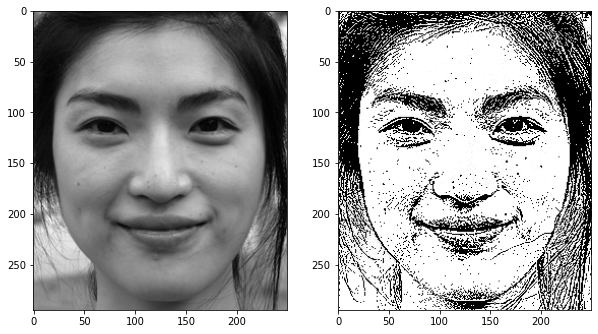

In [41]:
img_cv = cv2.imread('drive/MyDrive/COL783/subject1.png',cv2.IMREAD_GRAYSCALE) 
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_cv,cmap='gray')
dog_img = xdog(img_cv,sigma=0.4,k=0.1, tuo=1,epsilon=1,phi=12)
plt.subplot(1,2,2)
plt.imshow(dog_img,cmap='gray')

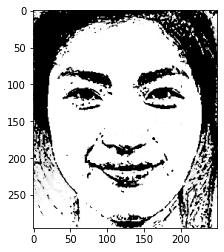

In [42]:
median = cv2.medianBlur(dog_img.astype('uint8'), 3)
plt.imshow(median,cmap='gray')

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No. of Traingles:  129
No. of Traingles:  129
total POints :  119460
Ignored Points :  0
Approximated Points :  0


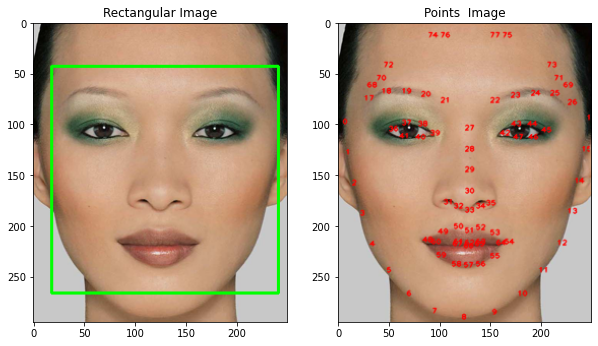

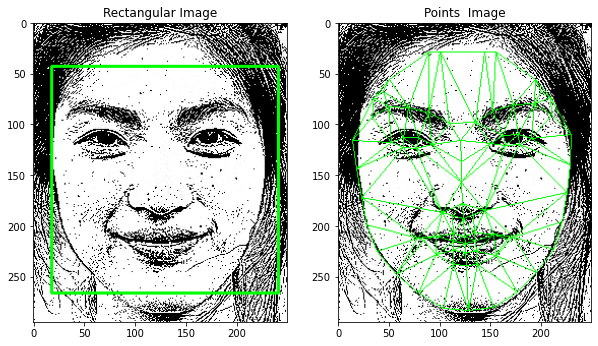

In [43]:
#warp
dog_rgb = np.copy(dog_img)
dog_rgb = color.gray2rgb(dog_rgb)
out3 = warp3(e1,dog_rgb.astype('uint8'))

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


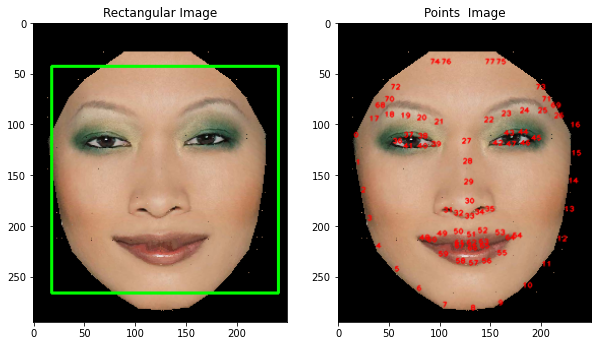

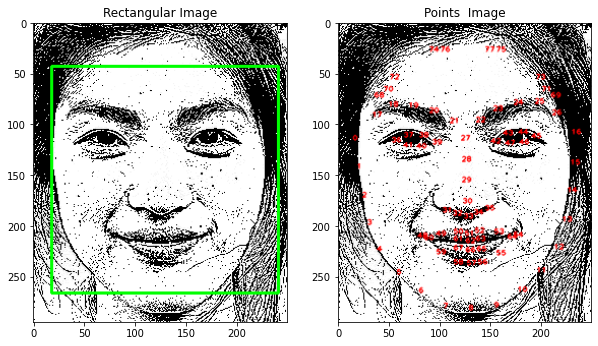

In [44]:
#layer_decomposition
dog_example_layers = layer_decomposition(out3)
dog_subject_layers = layer_decomposition(dog_rgb.astype('uint8'))

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


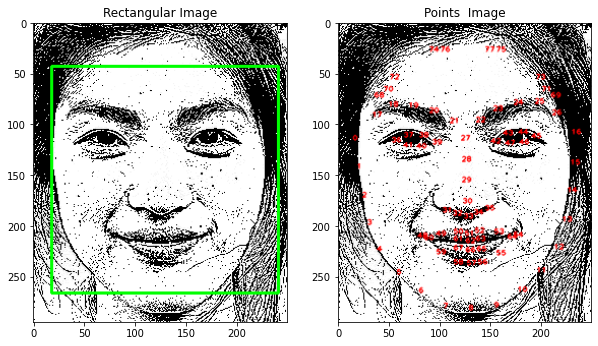

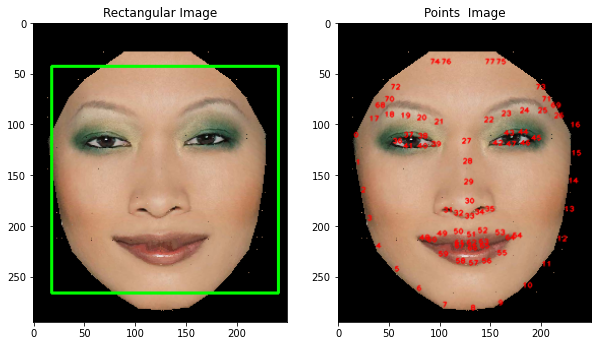

In [45]:
#mask creating
dog_mask_source = createMask(dog_rgb.astype('uint8'))
dog_mask_example = createMask(out3)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 3119 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


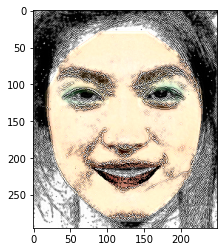

In [46]:
#combining the results
#layers: face structure, skin detail and color
final_result = np.zeros(s1.shape)
dog_mask_subject = dog_mask_source
dog_skin_detail_layer = skin_detail_transfer(dog_subject_layers[1],dog_example_layers[1]*dog_mask_subject[4],dog_mask_example,0)*(dog_mask_subject[4]-dog_mask_subject[0]-dog_mask_subject[1]-dog_mask_subject[3]) + (dog_subject_layers[1])*(1-dog_mask_subject[4]+dog_mask_subject[0]+dog_mask_subject[1]+dog_mask_subject[3])
dog_color_layers = color_transfer(dog_mask_subject,dog_subject_layers[2],dog_example_layers[2],1)
dog_highlight_shading = highlight_and_shading_transfer(dog_subject_layers[0],dog_example_layers[0],dog_mask_subject)
dog_lip_layer = lip_makeup(dog_rgb,out3,dog_mask_subject,dog_mask_example)

#face_str_layer + skin_detail_Layer = L*
#result[:,:,0] = skin_detail_layer*(1-mask_subject[0]-mask_subject[1]-mask_subject[3]) + subject_layers[0] + subject_layers[1]*(mask_subject[0]+mask_subject[1]+mask_subject[3])
final_result[:,:,0] = (dog_skin_detail_layer + dog_subject_layers[0])
final_result[:,:,1:] = dog_color_layers

#add higlight and skin detail layer to L channel
final_result[:,:,0] = final_result[:,:,0] + dog_highlight_shading 


#add lip makeup
temp2 = np.copy(dog_lip_layer)
grad_lip = cv2.Laplacian(temp2[:,:,0],cv2.CV_64F,ksize=1)

final_result[:,:,0] = dog_lip_layer[:,:,0]*(dog_mask_source[3]-dog_mask_source[2]) + (final_result[:,:,0])*(1 - dog_mask_source[3]+dog_mask_source[2])
final_result[:,:,1] = dog_lip_layer[:,:,1]*(dog_mask_source[3]-dog_mask_source[2]) + (final_result[:,:,1])*(1 - dog_mask_source[3]+dog_mask_source[2])
final_result[:,:,2] = dog_lip_layer[:,:,2]*(dog_mask_source[3]-dog_mask_source[2]) + (final_result[:,:,2])*(1 - dog_mask_source[3]+dog_mask_source[2])

temp = np.copy(final_result)
temp = color.lab2rgb(temp)
plt.imshow(temp)


Text(0.5, 1.0, 'Result of Makeup Transfer')

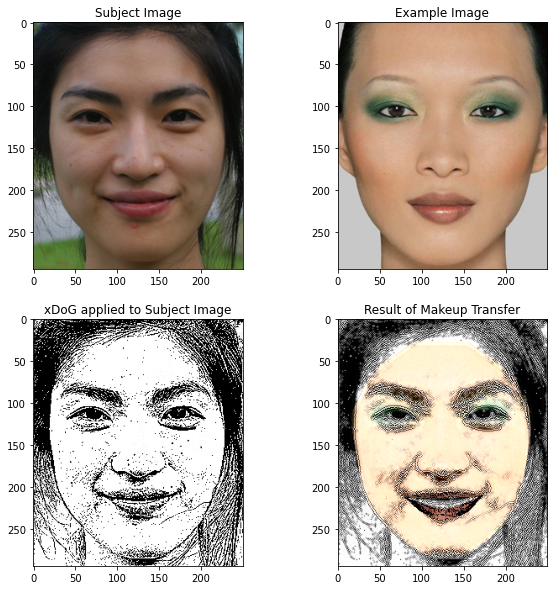

In [47]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(s1)
plt.title('Subject Image')
plt.subplot(2,2,2)
plt.imshow(e1)
plt.title('Example Image')
plt.subplot(2,2,3)
plt.imshow(dog_img,cmap='gray')
plt.title('xDoG applied to Subject Image')
plt.subplot(2,2,4)
plt.imshow(temp)
plt.title('Result of Makeup Transfer')

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No. of Traingles:  129
No. of Traingles:  129
total POints :  120102
Ignored Points :  0
Approximated Points :  0


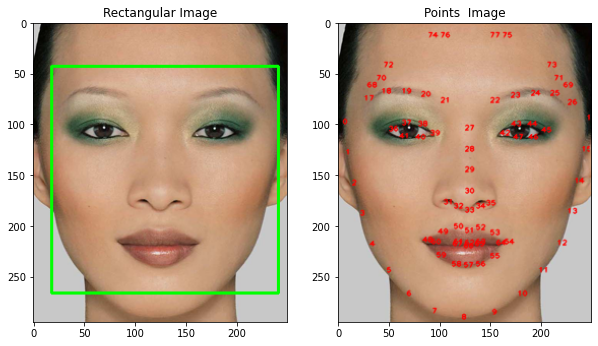

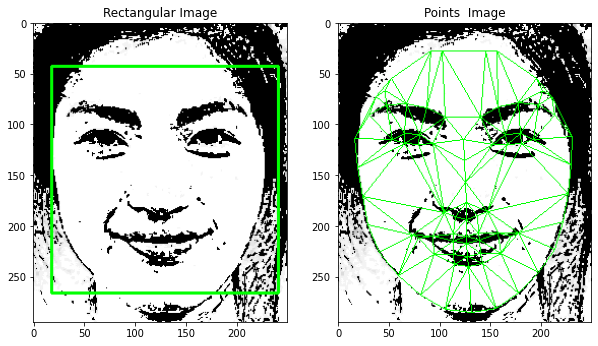

In [48]:
#now repeat the same procedure with median filtered image
#warping
dog_median = np.copy(median)
dog_median = color.gray2rgb(dog_median)
out4 = warp3(e1,dog_median.astype('uint8'))

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


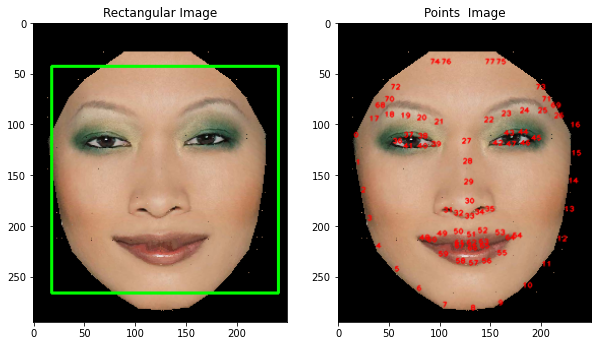

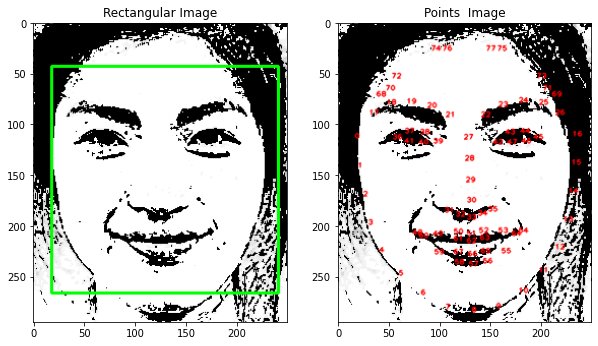

In [49]:
#layer decomposition
median_example_layers = layer_decomposition(out3)
median_subject_layers = layer_decomposition(dog_median.astype('uint8'))

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


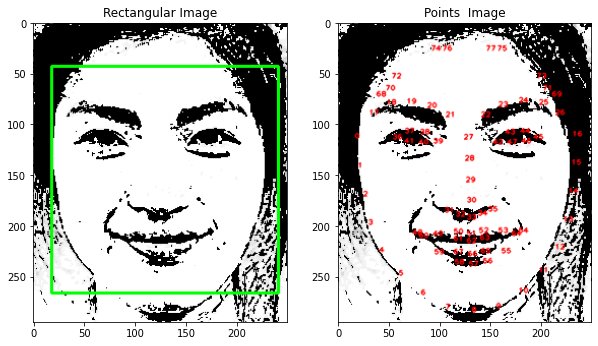

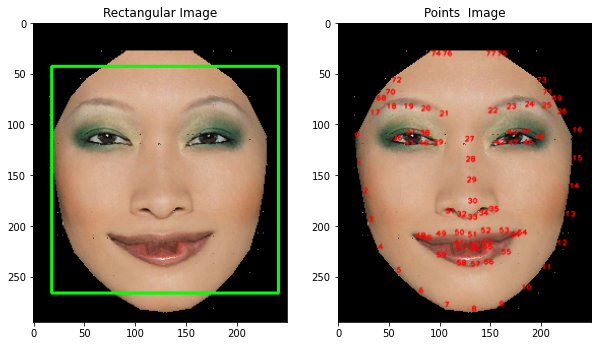

In [50]:
#mask creating
median_mask_source = createMask(dog_median.astype('uint8'))
median_mask_example = createMask(out4)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1262 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


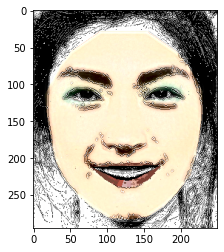

In [51]:
#combining the results
#layers: face structure, skin detail and color
final_result = np.zeros(s1.shape)
median_mask_subject = median_mask_source
dog_mask_subject = median_mask_source
dog_skin_detail_layer = skin_detail_transfer(median_subject_layers[1],median_example_layers[1]*median_mask_subject[4],median_mask_example,0)*(dog_mask_subject[4]-dog_mask_subject[0]-dog_mask_subject[1]-dog_mask_subject[3]) + (dog_subject_layers[1])*(1-dog_mask_subject[4]+dog_mask_subject[0]+dog_mask_subject[1]+dog_mask_subject[3])
dog_color_layers = color_transfer(median_mask_subject,median_subject_layers[2],median_example_layers[2],1)
dog_highlight_shading = highlight_and_shading_transfer(median_subject_layers[0],median_example_layers[0],dog_mask_subject)
dog_lip_layer = lip_makeup(dog_median,out4,dog_mask_subject,median_mask_example)

#face_str_layer + skin_detail_Layer = L*
#result[:,:,0] = skin_detail_layer*(1-mask_subject[0]-mask_subject[1]-mask_subject[3]) + subject_layers[0] + subject_layers[1]*(mask_subject[0]+mask_subject[1]+mask_subject[3])
final_result[:,:,0] = (dog_skin_detail_layer + median_subject_layers[0])
final_result[:,:,1:] = dog_color_layers

#add higlight and skin detail layer to L channel
final_result[:,:,0] = final_result[:,:,0] + dog_highlight_shading 


#add lip makeup
temp2 = np.copy(dog_lip_layer)
grad_lip = cv2.Laplacian(temp2[:,:,0],cv2.CV_64F,ksize=1)

final_result[:,:,0] = dog_lip_layer[:,:,0]*(dog_mask_source[3]-dog_mask_source[2]) + (final_result[:,:,0])*(1 - dog_mask_source[3]+dog_mask_source[2])
final_result[:,:,1] = dog_lip_layer[:,:,1]*(dog_mask_source[3]-dog_mask_source[2]) + (final_result[:,:,1])*(1 - dog_mask_source[3]+dog_mask_source[2])
final_result[:,:,2] = dog_lip_layer[:,:,2]*(dog_mask_source[3]-dog_mask_source[2]) + (final_result[:,:,2])*(1 - dog_mask_source[3]+dog_mask_source[2])

temp = np.copy(final_result)
temp = color.lab2rgb(temp)
plt.imshow(temp)


Text(0.5, 1.0, 'Result of Makeup Transfer')

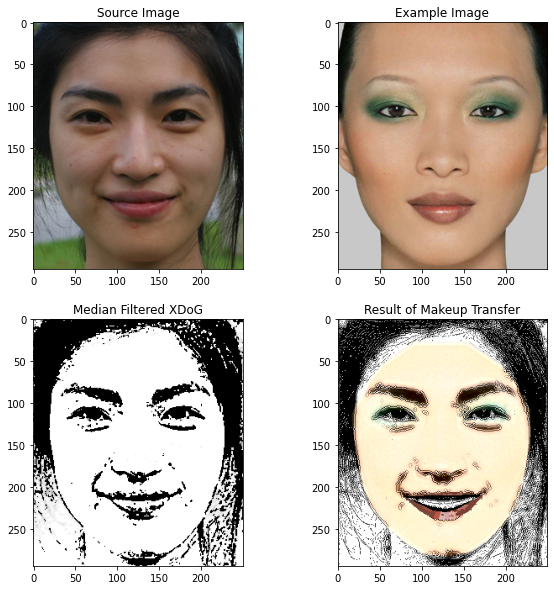

In [52]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(s1)
plt.title('Source Image')
plt.subplot(2,2,2)
plt.imshow(e1)
plt.title('Example Image')
plt.subplot(2,2,3)
plt.imshow(median,cmap='gray')
plt.title('Median Filtered XDoG')
plt.subplot(2,2,4)
plt.imshow(temp)
plt.title('Result of Makeup Transfer')

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No. of Traingles:  129
No. of Traingles:  130
total POints :  122742
Ignored Points :  0
Approximated Points :  0


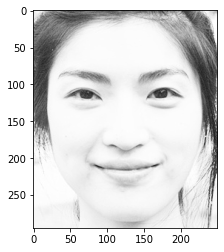

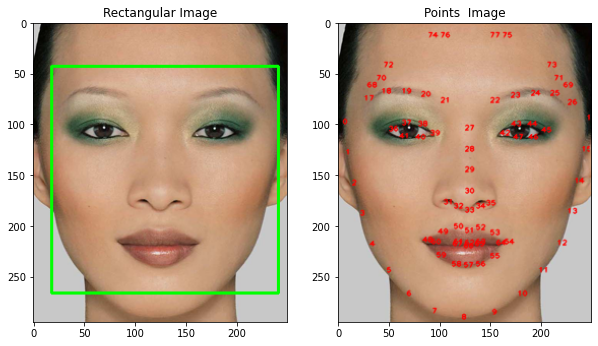

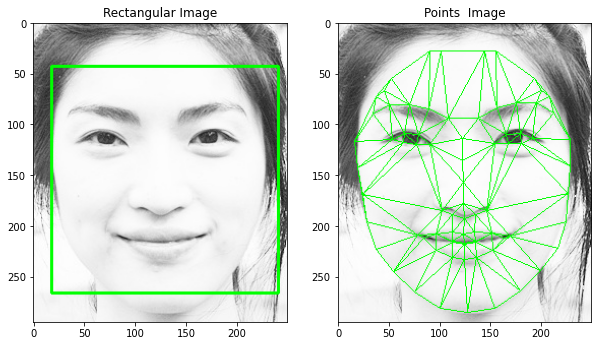

In [53]:
#now repeat the same procedure with median filtered image
#warping
newimg = cv2.imread('xdog.jpeg',cv2.IMREAD_GRAYSCALE)
plt.imshow(newimg,cmap='gray')
dog_img = np.copy(newimg)
dog_img = color.gray2rgb(dog_img)
out4 = warp3(e1,dog_img.astype('uint8'))

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


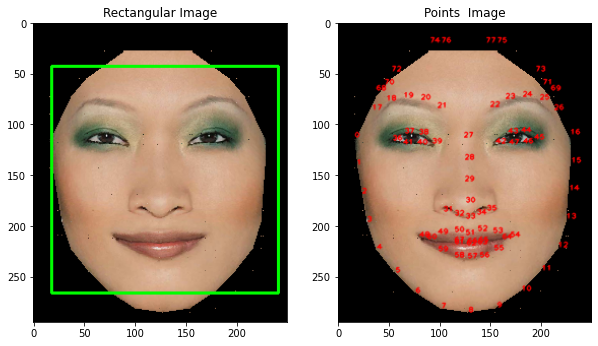

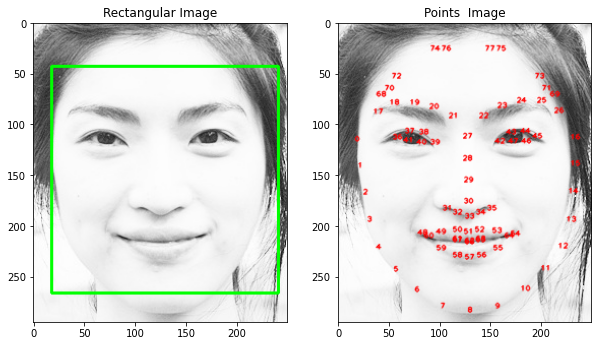

In [54]:
#layer decomposition
median_example_layers = layer_decomposition(out4)
median_subject_layers = layer_decomposition(dog_img.astype('uint8'))

No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43
No of Points:  68
[(18, 43) (241, 266)]
Left:  18 right:  241 bottom:  266 top:  43


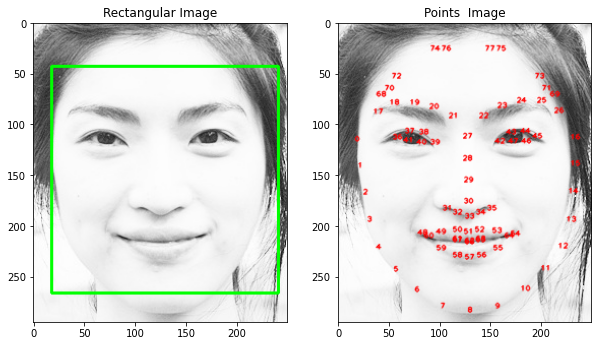

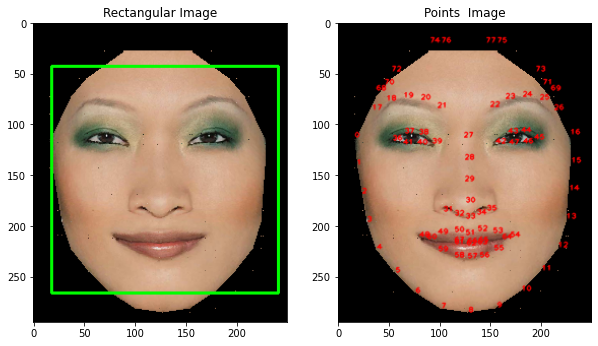

In [55]:
#mask creating
median_mask_source = createMask(dog_img.astype('uint8'))
median_mask_example = createMask(out4)

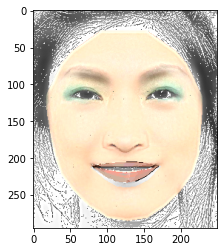

In [56]:
#combining the results
#layers: face structure, skin detail and color
final_result = np.zeros(s1.shape)
median_mask_subject = median_mask_source
dog_mask_subject = median_mask_source
dog_skin_detail_layer = skin_detail_transfer(median_subject_layers[1],median_example_layers[1]*median_mask_subject[4],median_mask_example,0)*(dog_mask_subject[4]-dog_mask_subject[0]-dog_mask_subject[1]-dog_mask_subject[3]) + (dog_subject_layers[1])*(1-dog_mask_subject[4]+dog_mask_subject[0]+dog_mask_subject[1]+dog_mask_subject[3])
dog_color_layers = color_transfer(median_mask_subject,median_subject_layers[2],median_example_layers[2],1)
dog_highlight_shading = highlight_and_shading_transfer(median_subject_layers[0],median_example_layers[0],dog_mask_subject)
dog_lip_layer = lip_makeup(dog_img,out4,dog_mask_subject,median_mask_example)

#face_str_layer + skin_detail_Layer = L*
#result[:,:,0] = skin_detail_layer*(1-mask_subject[0]-mask_subject[1]-mask_subject[3]) + subject_layers[0] + subject_layers[1]*(mask_subject[0]+mask_subject[1]+mask_subject[3])
final_result[:,:,0] = (dog_skin_detail_layer + median_subject_layers[0])
final_result[:,:,1:] = dog_color_layers

#add higlight and skin detail layer to L channel
final_result[:,:,0] = final_result[:,:,0] + dog_highlight_shading 


#add lip makeup
temp2 = np.copy(dog_lip_layer)
temp3 = np.copy(dog_img)
grad_lip = cv2.Laplacian(temp2[:,:,0],cv2.CV_64F,ksize=1)
grad_subject = cv2.Laplacian(temp3[:,:,0],cv2.CV_64F,ksize=1)
final_result[:,:,0] = dog_lip_layer[:,:,0]*(median_mask_example[3]-median_mask_example[2]) + (final_result[:,:,0])*(1 - median_mask_example[3] + median_mask_example[2])
#final_result[:,:,0] = final_result[:,:,0] + grad_subject*(mask_subject[3]-mask_subject[2])
final_result[:,:,1] = dog_lip_layer[:,:,1]*(dog_mask_source[3]-dog_mask_source[2]) + (final_result[:,:,1])*(1 - dog_mask_source[3]+dog_mask_source[2])
final_result[:,:,2] = dog_lip_layer[:,:,2]*(dog_mask_source[3]-dog_mask_source[2]) + (final_result[:,:,2])*(1 - dog_mask_source[3]+dog_mask_source[2])

temp = np.copy(final_result)
temp = color.lab2rgb(temp)
plt.imshow(temp)


Text(0.5, 1.0, 'Result of Makeup Transfer')

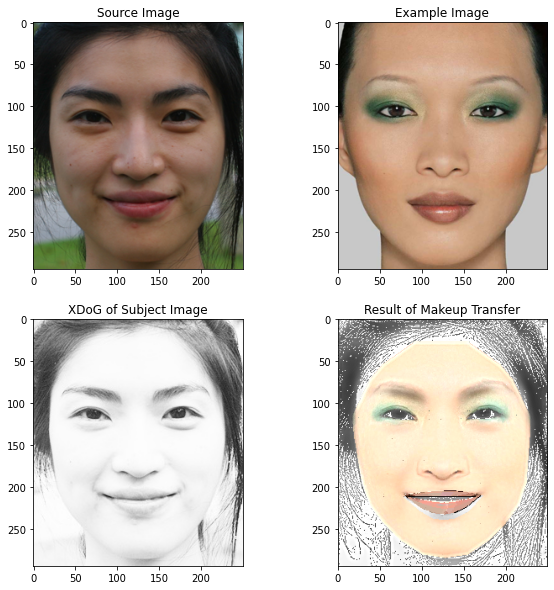

In [57]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(s1)
plt.title('Source Image')
plt.subplot(2,2,2)
plt.imshow(e1)
plt.title('Example Image')
plt.subplot(2,2,3)
plt.imshow(dog_img,cmap='gray')
plt.title('XDoG of Subject Image')
plt.subplot(2,2,4)
plt.imshow(temp)
plt.title('Result of Makeup Transfer')

In [58]:
'''
dog function for jupyter notebook:


def dog(img,size=(0,0),k=1.6,sigma=0.5,gamma=1):
    img1 = cv2.GaussianBlur(img,size,sigma)
    img2 = cv2.GaussianBlur(img,size,sigma*k)
    return (img1-gamma*img2)
def xdog_new_variant(img,sigma=0.5,k=1.6, gamma=1,epsilon=1,phi=1):
    aux = dog(img,sigma=sigma,k=k,gamma=gamma)/255
    for i in range(0,aux.shape[0]):
        for j in range(0,aux.shape[1]):
            if(aux[i,j] < epsilon):
                aux[i,j] = 255
            else:
                aux[i,j] = 255*(1 + np.tanh(phi*(aux[i,j])))
    return aux
img_cv = cv2.cvtColor(subject, cv2.COLOR_RGB2GRAY)
xdog_img = xdog_new_variant(img_cv,sigma=0.4,k=1.6,gamma=0.5,epsilon=-0.5,phi=10)
xdog_img = xdog_img.astype('uint8')
plt.imshow(xdog_img,cmap='gray')

cv2.imwrite("xdog_2.jpeg",xdog_img)
'''

'\ndog function for jupyter notebook:\n\n\ndef dog(img,size=(0,0),k=1.6,sigma=0.5,gamma=1):\n    img1 = cv2.GaussianBlur(img,size,sigma)\n    img2 = cv2.GaussianBlur(img,size,sigma*k)\n    return (img1-gamma*img2)\ndef xdog_new_variant(img,sigma=0.5,k=1.6, gamma=1,epsilon=1,phi=1):\n    aux = dog(img,sigma=sigma,k=k,gamma=gamma)/255\n    for i in range(0,aux.shape[0]):\n        for j in range(0,aux.shape[1]):\n            if(aux[i,j] < epsilon):\n                aux[i,j] = 255\n            else:\n                aux[i,j] = 255*(1 + np.tanh(phi*(aux[i,j])))\n    return aux\nimg_cv = cv2.cvtColor(subject, cv2.COLOR_RGB2GRAY)\nxdog_img = xdog_new_variant(img_cv,sigma=0.4,k=1.6,gamma=0.5,epsilon=-0.5,phi=10)\nxdog_img = xdog_img.astype(\'uint8\')\nplt.imshow(xdog_img,cmap=\'gray\')\n\ncv2.imwrite("xdog_2.jpeg",xdog_img)\n'

In [59]:
#-------------EXPERIMENTS--------------------------------

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 340 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


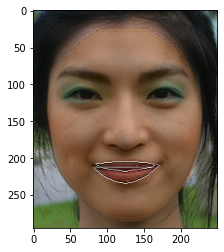

In [60]:
temp = np.copy(result)
temp[:,:,0] = temp[:,:,0] + grad_lip
temp = color.lab2rgb(temp)
plt.imshow(temp)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 186 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


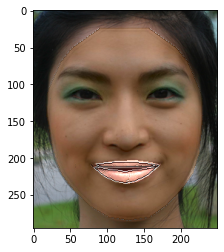

In [61]:
temp = np.copy(result)
temp[:,:,0] = temp[:,:,0] + grad_lip + lip_layer[:,:,0]
temp = color.lab2rgb(temp)
plt.imshow(temp)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1219 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


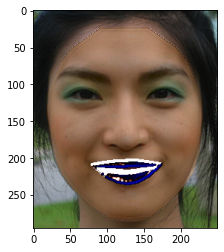

In [62]:
temp = np.copy(result)
temp[:,:,0] = temp[:,:,0] + grad_lipx + grad_lipy + grad_lip
temp = color.lab2rgb(temp)
plt.imshow(temp)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1163 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


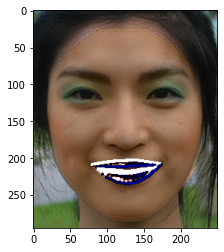

In [63]:
temp = np.copy(result)
temp[:,:,0] = temp[:,:,0] + grad_lipx + grad_lipy + grad_lip + lip_layer[:,:,0]
temp = color.lab2rgb(temp)
plt.imshow(temp)